In [1]:
!pip install tf-nightly-gpu

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:35_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.relgpu_drvr445TC445_37.28845127_0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import sklearn.metrics
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.5.0-dev20201111


In [5]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Data preprocessing

Split dataset to 50% training dataset , 25% test dataset and 25% validation dataset

In [6]:
data_dir = '../minc10'
print(os.path.exists(data_dir))

batch_size = 8
img_height = 362
img_width = 362

True


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.5,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 10 classes.
Using 12500 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.5,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 25000 files belonging to 10 classes.
Using 12500 files for validation.


Print all the classes

In [9]:
class_names = train_ds.class_names
print(class_names)

['fabric', 'foliage', 'glass', 'leather', 'metal', 'paper', 'plastic', 'stone', 'water', 'wood']


Show the first batch of images and labels from the training set

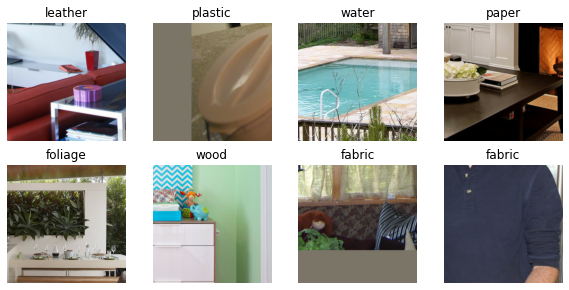

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Create the test dataset. Number of batches of data are available in the validation set is obtained using tf.data.experimental.cardinality and move 50% of them to a test set.

In [11]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Apply these layers to an image and see the result.

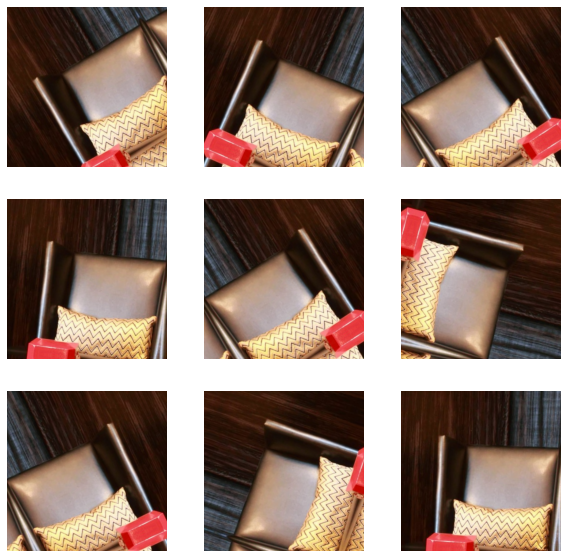

In [14]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

The model expects pixel values in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`.To rescale them, use the preprocessing method included with the model.

In [15]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [16]:
IMG_SHAPE = (img_height, img_width , 3) 
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 12, 12, 2048)


## Feature extraction
In this step, convolutional base created from the previous step is frozen and used as a feature extractor. In addition,a classifier is added on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before compiling and training the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. Xception has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [18]:
base_model.trainable = False

In [19]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 362, 362, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 180, 180, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 180, 180, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 180, 180, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial 12x12 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image and feed it to two dense layers.

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 2048)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. An activation function is not needed here because this prediction will be treated as a logit, or a raw prediction value.

In [21]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 10)


Build a model by chaining together the data augmentation, rescaling, base_model , feature extractor layers and two dense layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [22]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are ten classes, use a sparse categorical cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 362, 362, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 362, 362, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 362, 362, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 362, 362, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 12, 12, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

The 20M parameters in Xception are frozen, but there are 8.4M _trainable_ parameters in the Dense layers.  These are divided between six `tf.Variable` objects, the weights and biases.

In [25]:
len(model.trainable_variables)

6

### Train the model
train for 10 epochs


In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

782/782 [==============================] - 86s 84ms/step - loss: 2.3031 - accuracy: 0.1164


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.30
initial accuracy: 0.11


In [28]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
1563/1563 [==============================] - 224s 141ms/step - loss: 1.3039 - accuracy: 0.5597 - val_loss: 1.0704 - val_accuracy: 0.6363
Epoch 2/10
1563/1563 [==============================] - 220s 140ms/step - loss: 1.1206 - accuracy: 0.6256 - val_loss: 1.0044 - val_accuracy: 0.6572
Epoch 3/10
1563/1563 [==============================] - 220s 141ms/step - loss: 1.0610 - accuracy: 0.6389 - val_loss: 1.0071 - val_accuracy: 0.6545
Epoch 4/10
1563/1563 [==============================] - 220s 141ms/step - loss: 1.0291 - accuracy: 0.6509 - val_loss: 0.9921 - val_accuracy: 0.6566
Epoch 5/10
1563/1563 [==============================] - 220s 141ms/step - loss: 1.0076 - accuracy: 0.6572 - val_loss: 0.9745 - val_accuracy: 0.6583
Epoch 6/10
1563/1563 [==============================] - 220s 141ms/step - loss: 0.9809 - accuracy: 0.6652 - val_loss: 0.9677 - val_accuracy: 0.6636
Epoch 7/10
1563/1563 [==============================] - 220s 141ms/step - loss: 0.9630 - accuracy: 0.6734 - val_

### Learning curves

Learning curves of the training and validation accuracy/loss when using the Xception base model as a fixed feature extractor.

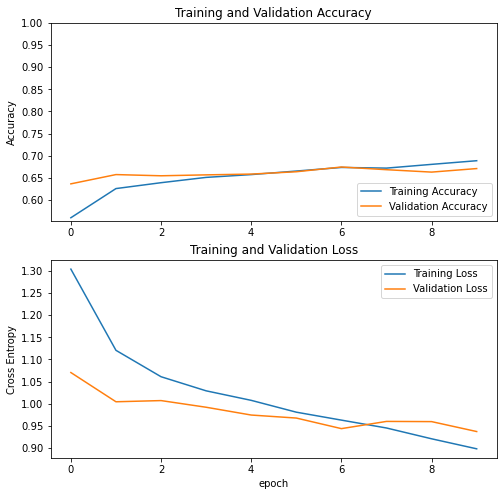

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, only a few layers on top of an Xception base model were being trained. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This is done after training the top-level classifier with the pre-trained model set to non-trainable. If a randomly initialized classifier is added on top of a pre-trained model and attempted to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and the pre-trained model will forget what it has learned.

Also, a small number of top layers is finetuned rather than the whole Xception model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

All you need to do is unfreeze the `base_model`. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [30]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


### Compile the model

As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [32]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 362, 362, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 362, 362, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 362, 362, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 362, 362, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 12, 12, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [34]:
len(model.trainable_variables)

105

### Continue training the model

In [35]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/25
1563/1563 [==============================] - 460s 290ms/step - loss: 0.8084 - accuracy: 0.7190 - val_loss: 0.7057 - val_accuracy: 0.7679
Epoch 11/25
1563/1563 [==============================] - 453s 290ms/step - loss: 0.6419 - accuracy: 0.7858 - val_loss: 0.6384 - val_accuracy: 0.7913
Epoch 12/25
1563/1563 [==============================] - 453s 290ms/step - loss: 0.5693 - accuracy: 0.8102 - val_loss: 0.6151 - val_accuracy: 0.7981
Epoch 13/25
1563/1563 [==============================] - 451s 289ms/step - loss: 0.5241 - accuracy: 0.8254 - val_loss: 0.5840 - val_accuracy: 0.8068
Epoch 14/25
1563/1563 [==============================] - 452s 289ms/step - loss: 0.4883 - accuracy: 0.8417 - val_loss: 0.5668 - val_accuracy: 0.8141
Epoch 15/25
1563/1563 [==============================] - 452s 289ms/step - loss: 0.4454 - accuracy: 0.8540 - val_loss: 0.5787 - val_accuracy: 0.8140
Epoch 16/25
1563/1563 [==============================] - 452s 289ms/step - loss: 0.4108 - accuracy: 0.8557

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

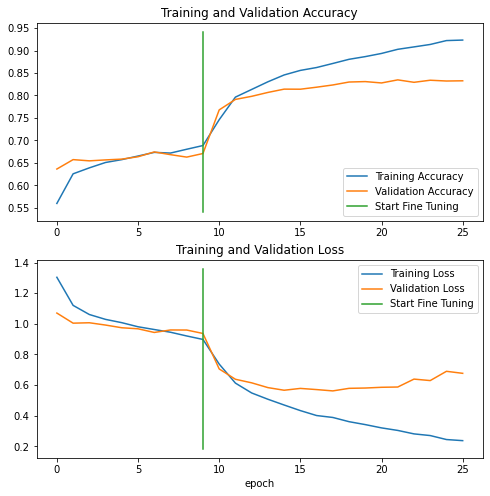

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
#pip install -q pyyaml h5py

### Save the model weights

In [39]:
model.save_weights('./my_checkpoint')

### Predict and display the first batch of images in test dataset

Predictions:
 [7 7 6 1 9 4 0 1]
Labels:
 [7 7 6 1 9 4 0 1]


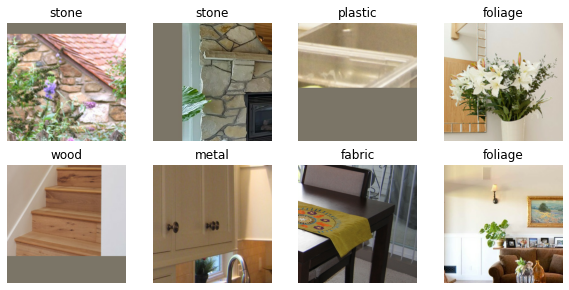

In [40]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = np.argmax(predictions, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(batch_size):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Test Accuracy

In [41]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

781/781 [==============================] - 65s 84ms/step - loss: 0.7020 - accuracy: 0.8318
Test accuracy : 0.8317861557006836


### Visualize results using confusion matrix

In [42]:
pred = np.array([])
labels = np.array([])
for image_batch, y in test_ds.as_numpy_iterator():
    predictions = model.predict_on_batch(image_batch)
    predictions = np.argmax(predictions, axis=1)
    pred = np.concatenate((pred, predictions), axis=0)
    labels = np.concatenate((labels, y), axis=0)
# Calculate the confusion matrix.
cm = sklearn.metrics.confusion_matrix(labels, pred)
# Log the confusion matrix as an image summary.
print(cm)

[[525   2  22  47  13  18  30   3   3  18]
 [  0 572  13   0   4   2   4   7   4   1]
 [  1  22 501   1  34  10  25   4  11  12]
 [ 54   2   4 534  15   5  12   0   3  23]
 [  2   2  37   4 492   5  48   4   2  23]
 [  8   2  14   5  19 530  45   0   1  10]
 [ 14   6  28   8  45  22 440   4   7   8]
 [  5   7   6   0   6   0   2 527  27  18]
 [  0   5  14   0   4   0   2  20 602   1]
 [ 11   1  29  17  38  11  14   9   4 472]]


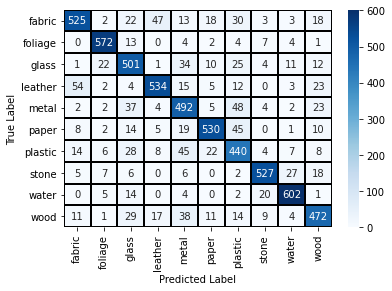

In [43]:
fig = sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = class_names , yticklabels = class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show(fig)